<a href="https://colab.research.google.com/github/Indukurivigneshvarma/Deep_Learning/blob/main/Time_Series/Anamoly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip uninstall prophet pystan cmdstanpy -y
!pip install prophet cmdstanpy  -q
from IPython.display import clear_output
clear_output(wait=True)

Found existing installation: prophet 1.2.1
Uninstalling prophet-1.2.1:
  Successfully uninstalled prophet-1.2.1
Found existing installation: cmdstanpy 1.3.0
Uninstalling cmdstanpy-1.3.0:
  Successfully uninstalled cmdstanpy-1.3.0


In [3]:
from prophet import Prophet

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv"
df = pd.read_csv(url)

df.columns = df.columns.str.strip().str.capitalize()

df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.asfreq('D')

In [6]:
print("Missing values before fix:", df['Temp'].isna().sum())

df['Temp'] = df['Temp'].fillna(method='ffill')

print("Missing values after fix:", df['Temp'].isna().sum())

Missing values before fix: 2
Missing values after fix: 0


/tmp/ipython-input-832157111.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Temp'] = df['Temp'].fillna(method='ffill')


In [7]:
prophet_df = df.reset_index().rename(columns={'Date': 'ds', 'Temp': 'y'})
prophet_df['ds'] = pd.to_datetime(prophet_df['ds'])

In [8]:
print(prophet_df.head())

          ds     y
0 1981-01-01  20.7
1 1981-01-02  17.9
2 1981-01-03  18.8
3 1981-01-04  14.6
4 1981-01-05  15.8


In [9]:
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode='additive'
)
model.fit(prophet_df)


In [10]:
print(prophet_df.columns)
print(prophet_df.head())

Index(['ds', 'y'], dtype='object')
          ds     y
0 1981-01-01  20.7
1 1981-01-02  17.9
2 1981-01-03  18.8
3 1981-01-04  14.6
4 1981-01-05  15.8


In [14]:
future = model.make_future_dataframe(periods=0)
forecast = model.predict(future)

In [15]:
result = prophet_df.merge(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds')

In [16]:
result['residual'] = result['y'] - result['yhat']

In [17]:
mean_resid = result['residual'].mean()
std_resid = result['residual'].std()
threshold_upper = mean_resid + 3 * std_resid
threshold_lower = mean_resid - 3 * std_resid

In [18]:
result['anomaly'] = ((result['residual'] > threshold_upper) | (result['residual'] < threshold_lower)).astype(int)

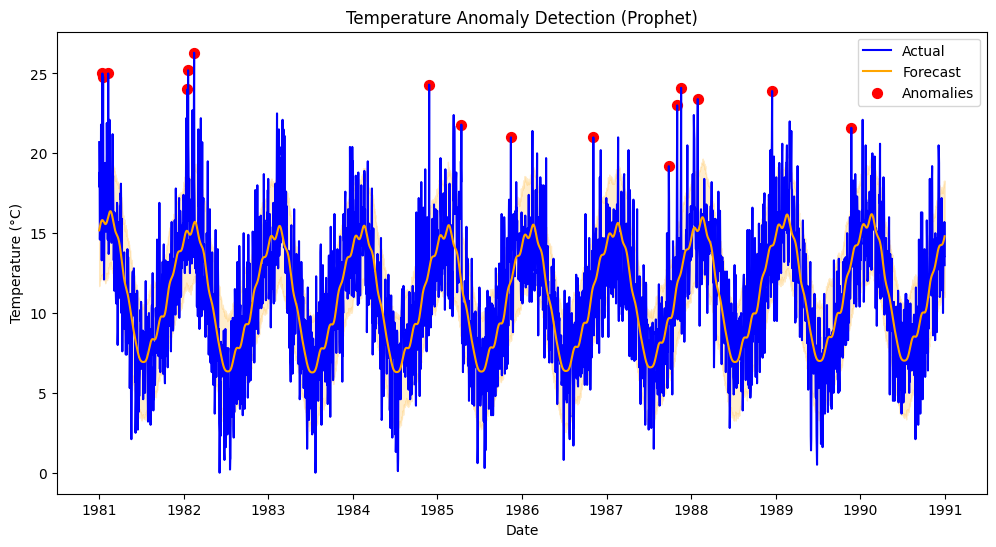

In [19]:
plt.figure(figsize=(12,6))
plt.plot(result['ds'], result['y'], label='Actual', color='blue')
plt.plot(result['ds'], result['yhat'], label='Forecast', color='orange')
plt.scatter(result.loc[result['anomaly'] == 1, 'ds'],
            result.loc[result['anomaly'] == 1, 'y'],
            color='red', label='Anomalies', s=50)
plt.fill_between(result['ds'], result['yhat_lower'], result['yhat_upper'], alpha=0.2, color='orange')
plt.title('Temperature Anomaly Detection (Prophet)')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

In [20]:
anomalies = result[result['anomaly'] == 1][['ds', 'y', 'yhat', 'residual']]
print("Detected anomalies:\n", anomalies.head())

Detected anomalies:
             ds     y       yhat   residual
14  1981-01-15  25.0  15.820277   9.179723
17  1981-01-18  24.8  15.781113   9.018887
39  1981-02-09  25.0  16.019775   8.980225
381 1982-01-17  24.0  15.133075   8.866925
384 1982-01-20  25.2  15.069041  10.130959
